## Final Project Submission

Please fill out:
* Student name: Jacob Crabb/ Taeho Jeon
* Student pace: full time 
* Instructor name: Greg/Miles
* Blog post URL:


In [2]:
#import our libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [3]:
#set our dataframe
df = pd.read_csv('kc_house_data.csv')

In [4]:
#check out some of the column values
print(df.condition.unique())

print(df.grade.unique())

[3 5 4 1 2]
[ 7  6  8 11  9  5 10 12  4  3 13]


In [42]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
#see what relates to what
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.004176,0.011592,-0.023803,0.008188,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.395734,0.036056,0.667951,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.078523,0.026496,0.356563,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,0.186451,-0.126479,0.665838,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,0.282532,-0.059445,0.762779,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.023143,0.075298,-0.008830,0.114731,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.021883,0.028436,-0.264075,0.458794,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
waterfront,-0.004176,0.276295,-0.002386,0.067282,0.110230,0.023143,0.021883,1.000000,0.406654,0.017642,0.087383,0.075463,-0.026079,0.087244,0.031057,-0.012772,-0.039864,0.088860,0.032002
view,0.011592,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,0.249727,0.166299,-0.054564,0.100964,0.085277,0.006141,-0.077894,0.279561,0.073332
condition,-0.023803,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.017642,0.045735,1.000000,-0.146896,-0.158904,-0.361592,-0.061858,0.002888,-0.015102,-0.105877,-0.093072,-0.003126


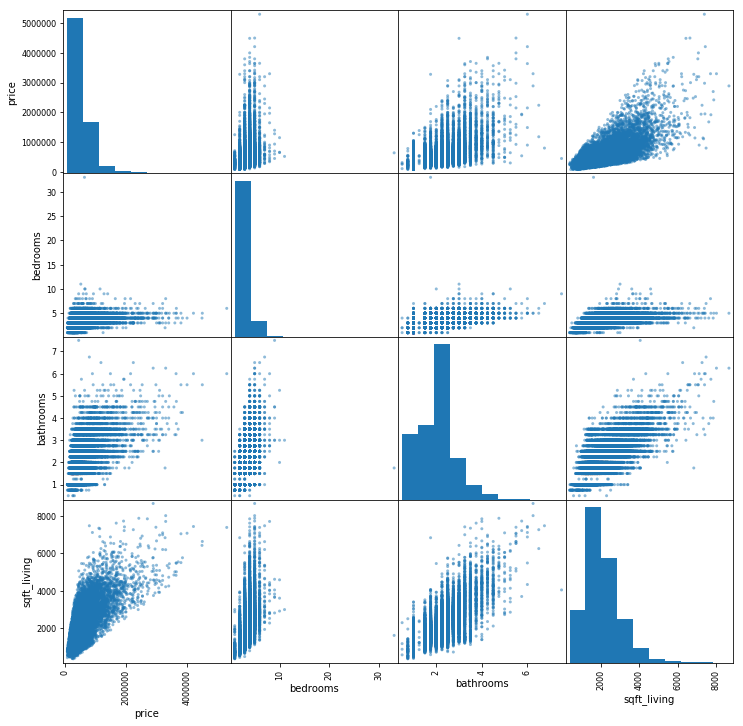

In [37]:
_ = pd.plotting.scatter_matrix(df[['price', 'bedrooms', 'bathrooms', 'sqft_living']], figsize=(12, 12))

In [6]:
#look at the low end of values
df.price.sort_values().head()

15279    78000.0
465      80000.0
16184    81000.0
8267     82000.0
2139     82500.0
Name: price, dtype: float64

In [7]:
#look at the high end of the values
df.price.sort_values().tail()

1446    5350000.0
4407    5570000.0
9245    6890000.0
3910    7060000.0
7245    7700000.0
Name: price, dtype: float64

In [8]:
#make sure that all the values are numbers
df.price.isna().sum()

0

In [9]:
#check out just teh square foot living column
df.sqft_living.describe()

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

In [10]:
#general information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


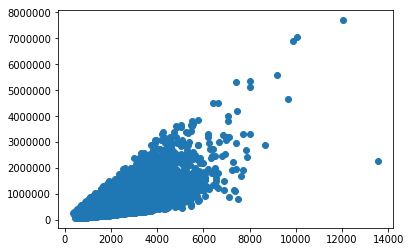

In [11]:
#set some variables for our first plot
X = df.sqft_living
y = df.price

plt.scatter(X, y)

In [12]:
#go for a more advanced attempt at least squares regression
slope, intercept, rvalue, pvalue, stderr = linregress(X,y)

first_model_y = slope*X + intercept

In [13]:
#check out our regression variables
linregress(X,y)

LinregressResult(slope=280.8630143588746, intercept=-43988.892194227315, rvalue=0.7019173021377599, pvalue=0.0, stderr=1.9394099144299841)

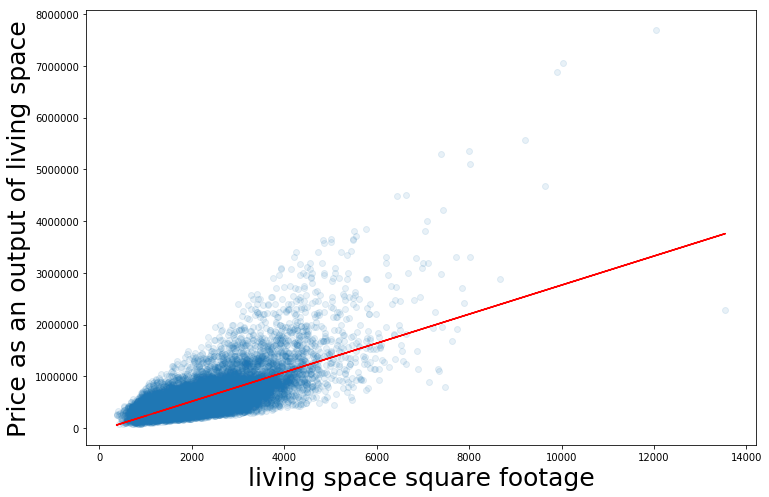

In [14]:
#plot our regression
fig = plt.figure(figsize=(12,8))
plt.scatter(X,y, alpha=0.10)
plt.plot(X, first_model_y, color='red')
plt.xlabel('living space square footage',fontsize=25)
plt.ylabel('Price as an output of living space',fontsize=25)
plt.show()

In [15]:
#look at our models outputs
first_model_y.describe()

count    2.159700e+04
mean     5.402966e+05
std      2.578621e+05
min      5.993042e+04
25%      3.576452e+05
50%      4.924595e+05
75%      6.722118e+05
max      3.758896e+06
Name: sqft_living, dtype: float64

In [16]:
#find upper quartile
df[df.price > 6.722118e+05].head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
21,2524049179,8/26/2014,2000000.0,3,2.75,3050,44867,1.0,0.0,4.0,...,9,2330,720.0,1968,0.0,98040,47.5316,-122.233,4110,20336
26,1794500383,6/26/2014,937000.0,3,1.75,2450,2691,2.0,0.0,0.0,...,8,1750,700.0,1915,NaN,98119,47.6386,-122.360,1760,3573
29,1873100390,3/2/2015,719000.0,4,2.50,2570,7173,2.0,0.0,0.0,...,8,2570,0.0,2005,0.0,98052,47.7073,-122.110,2630,6026
32,461000390,6/24/2014,687500.0,4,1.75,2330,5000,1.5,0.0,0.0,...,7,1510,820.0,1929,0.0,98117,47.6823,-122.368,1460,5000


In [17]:
#find the lower quartile
df[df.price < 3.576452e+05].head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,...,7,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,...,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113


In [18]:
#look at the low end of square foot
df.sqft_living.sort_values().tail()

8085      9640
9245      9890
3910     10040
7245     12050
12764    13540
Name: sqft_living, dtype: int64

In [19]:
#drop our first outlier
df = df.drop(index=12764)

In [20]:
#check to make sure it's gone
df.loc[df.index == 12764]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


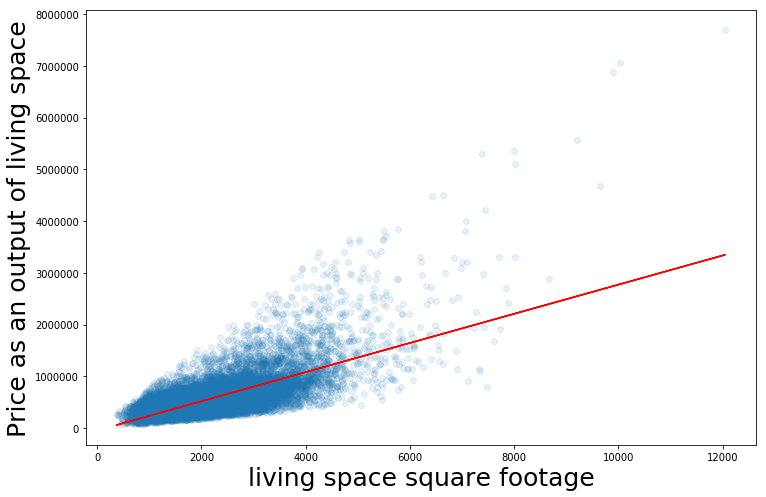

In [21]:
#see how that affects our regression
X = df.sqft_living
y = df.price

slope, intercept, rvalue, pvalue, stderr = linregress(X,y)

first_model_y = slope*X + intercept

linregress(X,y)

fig = plt.figure(figsize=(12,8))
plt.scatter(X,y, alpha=0.10)
plt.plot(X, first_model_y, color='red')
plt.xlabel('living space square footage',fontsize=25)
plt.ylabel('Price as an output of living space',fontsize=25)
plt.show()

In [22]:
#finding many outliers
remove_outliers = df.loc[(df.price >= 4500000) & (df.sqft_living >= 8000)].index

In [23]:
#remove those many outliers
df = df.drop(index=remove_outliers)

LinregressResult(slope=271.48382562201607, intercept=-25542.826878536027, rvalue=0.6956774973134765, pvalue=0.0, stderr=1.9080006609072122)


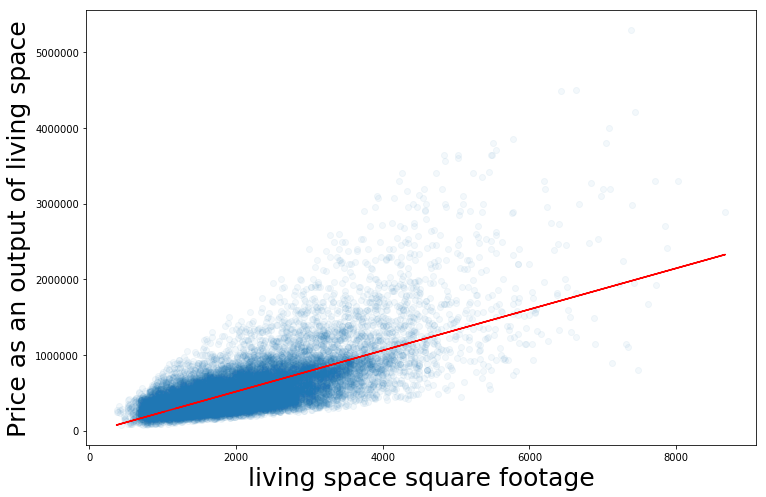

In [24]:
#see our new regression now that many extravaganatly
#large and expensive houses have been removed
X = df.sqft_living
y = df.price

slope, intercept, rvalue, pvalue, stderr = linregress(X,y)

first_model_y = slope*X + intercept

print(linregress(X,y))

fig = plt.figure(figsize=(12,8))
plt.scatter(X,y, alpha=0.05)
plt.plot(X, first_model_y, color='red')
plt.xlabel('living space square footage',fontsize=25)
plt.ylabel('Price as an output of living space',fontsize=25)
plt.show()

In [25]:
#write a function to return a prediction based on square footage
def return_predicted_value(x, slope, intercept):
    return slope*x + intercept

In [26]:
#see our results
return_predicted_value(8000, slope, intercept)

2146327.7780975928

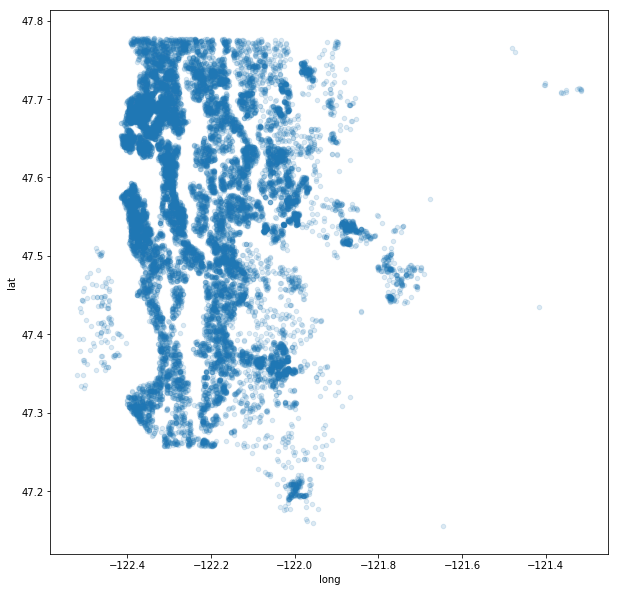

In [33]:
plot = df.plot(kind='scatter', x='long', y='lat', alpha=0.15, figsize=(10,10))

/Users/teo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


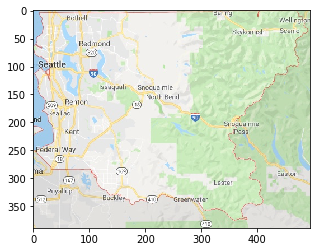

In [32]:
from scipy.misc import imread
img = imread('map.png')
plt.imshow(img,zorder=0)
plt.plot = plot
plt.show()


In [40]:
df.head().T

,0,1,2,3,4
id,7129300520,6414100192,5631500400,2487200875,1954400510
date,10/13/2014,12/9/2014,2/25/2015,12/9/2014,2/18/2015
price,221900,538000,180000,604000,510000
bedrooms,3,3,2,4,3
bathrooms,1,2.25,1,3,2
sqft_living,1180,2570,770,1960,1680
sqft_lot,5650,7242,10000,5000,8080
floors,1,2,1,1,1
waterfront,NaN,0,0,0,0
view,0,0,0,0,0


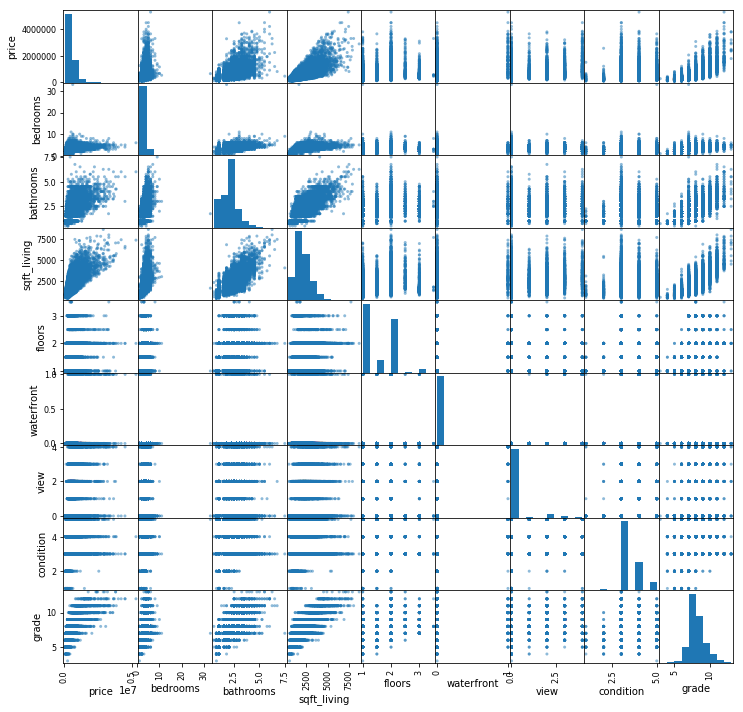

In [41]:
_ = pd.plotting.scatter_matrix(df[['price', 'bedrooms', 'bathrooms', 
                                   'sqft_living', 'floors', 'waterfront', 
                                   'view', 'condition', 'grade']], figsize=(12, 12))